In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
# ========== DATA PREPROCESSING ==========
print("Loading and preprocessing data...")

# Load dataset
df = pd.read_csv("dataset_stunting.csv")

# Drop kolom tidak digunakan
df.drop(columns=["Tanggal_Pengukuran", "TB_U", "ZS_TB_U"], inplace=True)

# Imputasi nilai kosong
num_cols = ["BB_Lahir", "TB_Lahir", "Umur", "Berat", "Tinggi"]
imputer = SimpleImputer(strategy="mean")
df[num_cols] = imputer.fit_transform(df[num_cols])
joblib.dump(imputer, "imputer.pkl")

# Encode kolom kategorikal
jk_encoder = LabelEncoder()
df["JK"] = jk_encoder.fit_transform(df["JK"])
joblib.dump(jk_encoder, "jk_encoder.pkl")

status_encoder = LabelEncoder()
df["Status"] = status_encoder.fit_transform(df["Status"])
joblib.dump(status_encoder, "status_encoder.pkl")

print(f"Class distribution before balancing:")
print(df["Status"].value_counts())

# Undersampling agar seimbang
min_class = df["Status"].value_counts().min()
df_balanced = df.groupby("Status").apply(lambda x: x.sample(min_class, random_state=42)).reset_index(drop=True)

print(f"Class distribution after balancing:")
print(df_balanced["Status"].value_counts())

# Split fitur dan target
X = df_balanced.drop(columns="Status")
y = df_balanced["Status"]

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, "scaler.pkl")

# Train-test split
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Loading and preprocessing data...
Class distribution before balancing:
Status
0    1946
2    1938
1     726
Name: count, dtype: int64
Class distribution after balancing:
Status
0    726
1    726
2    726
Name: count, dtype: int64
Train set size: 1306
Validation set size: 436
Test set size: 436


<ipython-input-2-2243189128>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby("Status").apply(lambda x: x.sample(min_class, random_state=42)).reset_index(drop=True)


In [3]:
# ========== BASELINE MODELS ==========
print("\n" + "="*50)
print("BASELINE MODELS EVALUATION")
print("="*50)

baseline_results = {}

# 1. Logistic Regression
print("\n1. Training Logistic Regression...")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_val)
lr_accuracy = accuracy_score(y_val, lr_pred)
baseline_results['Logistic Regression'] = lr_accuracy
print(f"Logistic Regression Validation Accuracy: {lr_accuracy:.4f}")

# 2. Random Forest
print("\n2. Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_val)
rf_accuracy = accuracy_score(y_val, rf_pred)
baseline_results['Random Forest'] = rf_accuracy
print(f"Random Forest Validation Accuracy: {rf_accuracy:.4f}")

# 3. SVM
print("\n3. Training SVM...")
svm_model = SVC(random_state=42, probability=True)
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_val)

svm_accuracy = accuracy_score(y_val, svm_pred)
baseline_results['SVM'] = svm_accuracy
print(f"SVM Validation Accuracy: {svm_accuracy:.4f}")


BASELINE MODELS EVALUATION

1. Training Logistic Regression...
Logistic Regression Validation Accuracy: 0.7706

2. Training Random Forest...
Random Forest Validation Accuracy: 0.8005

3. Training SVM...
SVM Validation Accuracy: 0.7729


In [4]:
# 4. Simple Neural Network (Baseline) - CUSTOM BUILT
print("\n4. Training Custom Neural Network (Baseline)...")

# Custom Neural Network built from scratch with TensorFlow (not using pre-trained models)
class CustomNeuralNetwork:
    def __init__(self, input_dim, hidden_dims, output_dim, learning_rate=0.001):
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        self.build_model()

    def build_model(self):
        """Build custom neural network architecture"""
        self.model = keras.Sequential()
        self.model.add(keras.layers.Input(shape=(self.input_dim,)))

        # Add hidden layers
        for hidden_dim in self.hidden_dims:
            self.model.add(keras.layers.Dense(hidden_dim, activation='relu'))
            self.model.add(keras.layers.Dropout(0.3))

        # Output layer
        self.model.add(keras.layers.Dense(self.output_dim, activation='softmax'))

        # Compile with custom optimizer
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

    def train(self, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
        """Train the model"""
        early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop],
            verbose=0
        )
        return history

    def predict(self, X):
        """Make predictions"""
        return self.model.predict(X, verbose=0)

# Create and train baseline neural network
baseline_nn = CustomNeuralNetwork(
    input_dim=X_train.shape[1],
    hidden_dims=[64, 32],
    output_dim=len(np.unique(y)),
    learning_rate=0.001
)

baseline_history = baseline_nn.train(X_train, y_train, X_val, y_val)
baseline_nn_pred = np.argmax(baseline_nn.predict(X_val), axis=1)
baseline_nn_accuracy = accuracy_score(y_val, baseline_nn_pred)
baseline_results['Custom Neural Network'] = baseline_nn_accuracy
print(f"Custom Neural Network Validation Accuracy: {baseline_nn_accuracy:.4f}")


4. Training Custom Neural Network (Baseline)...
Custom Neural Network Validation Accuracy: 0.8716


In [5]:
# Print baseline summary
print("\n" + "="*30)
print("BASELINE RESULTS SUMMARY")
print("="*30)
for model_name, accuracy in baseline_results.items():
    print(f"{model_name}: {accuracy:.4f}")

best_baseline = max(baseline_results, key=baseline_results.get)
best_baseline_score = baseline_results[best_baseline]
print(f"\nBest Baseline Model: {best_baseline} ({best_baseline_score:.4f})")


BASELINE RESULTS SUMMARY
Logistic Regression: 0.7706
Random Forest: 0.8005
SVM: 0.7729
Custom Neural Network: 0.8716

Best Baseline Model: Custom Neural Network (0.8716)


In [6]:
# ========== MANUAL HYPERPARAMETER TUNING ==========
print("\n" + "="*50)
print("MANUAL HYPERPARAMETER TUNING")
print("="*50)

# Define hyperparameter combinations to test manually
hyperparameter_configs = [
    {
        'hidden_dims': [128, 64],
        'learning_rate': 0.001,
        'dropout_rate': 0.3,
        'batch_size': 32
    },
    {
        'hidden_dims': [256, 128, 64],
        'learning_rate': 0.0005,
        'dropout_rate': 0.4,
        'batch_size': 64
    },
    {
        'hidden_dims': [512, 256, 128],
        'learning_rate': 0.001,
        'dropout_rate': 0.5,
        'batch_size': 32
    },
    {
        'hidden_dims': [128, 64, 32],
        'learning_rate': 0.01,
        'dropout_rate': 0.2,
        'batch_size': 16
    },
    {
        'hidden_dims': [256, 128],
        'learning_rate': 0.0001,
        'dropout_rate': 0.3,
        'batch_size': 64
    }
]

class TunedNeuralNetwork:
    def __init__(self, input_dim, hidden_dims, output_dim, learning_rate=0.001, dropout_rate=0.3):
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self.build_model()

    def build_model(self):
        """Build tuned neural network architecture"""
        self.model = keras.Sequential()
        self.model.add(keras.layers.Input(shape=(self.input_dim,)))

        # Add hidden layers with batch normalization
        for i, hidden_dim in enumerate(self.hidden_dims):
            self.model.add(keras.layers.Dense(hidden_dim, activation='relu'))
            self.model.add(keras.layers.BatchNormalization())
            self.model.add(keras.layers.Dropout(self.dropout_rate))

        # Output layer
        self.model.add(keras.layers.Dense(self.output_dim, activation='softmax'))

        # Compile with tuned parameters
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

    def train(self, X_train, y_train, X_val, y_val, epochs=150, batch_size=32):
        """Train the model with enhanced callbacks"""
        callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5, min_lr=1e-7)
        ]

        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=0
        )
        return history

    def predict(self, X):
        """Make predictions"""
        return self.model.predict(X, verbose=0)


# Test different configurations
best_config = None
best_accuracy = 0
best_model = None

print("Testing different hyperparameter configurations...")
for i, config in enumerate(hyperparameter_configs):
    print(f"\nConfiguration {i+1}: {config}")

    # Create and train model
    model = TunedNeuralNetwork(
        input_dim=X_train.shape[1],
        hidden_dims=config['hidden_dims'],
        output_dim=len(np.unique(y)),
        learning_rate=config['learning_rate'],
        dropout_rate=config['dropout_rate']
    )

    history = model.train(
        X_train, y_train, X_val, y_val,
        batch_size=config['batch_size']
    )

    # Evaluate
    predictions = np.argmax(model.predict(X_val), axis=1)
    accuracy = accuracy_score(y_val, predictions)

    print(f"Validation Accuracy: {accuracy:.4f}")

    # Check if current configuration is better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_config = config

print(f"\nBest Configuration: {best_config}")
print(f"Best Validation Accuracy: {best_accuracy:.4f}")


MANUAL HYPERPARAMETER TUNING
Testing different hyperparameter configurations...

Configuration 1: {'hidden_dims': [128, 64], 'learning_rate': 0.001, 'dropout_rate': 0.3, 'batch_size': 32}
Validation Accuracy: 0.8739

Configuration 2: {'hidden_dims': [256, 128, 64], 'learning_rate': 0.0005, 'dropout_rate': 0.4, 'batch_size': 64}
Validation Accuracy: 0.8624

Configuration 3: {'hidden_dims': [512, 256, 128], 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}
Validation Accuracy: 0.8876

Configuration 4: {'hidden_dims': [128, 64, 32], 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 16}
Validation Accuracy: 0.8578

Configuration 5: {'hidden_dims': [256, 128], 'learning_rate': 0.0001, 'dropout_rate': 0.3, 'batch_size': 64}
Validation Accuracy: 0.8165

Best Configuration: {'hidden_dims': [512, 256, 128], 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}
Best Validation Accuracy: 0.8876


In [7]:
# ========== FINAL MODEL TRAINING ==========
print("\n" + "="*50)
print("TRAINING FINAL MODEL")
print("="*50)

# Train final model with best configuration
final_model = TunedNeuralNetwork(
    input_dim=X_train.shape[1],
    hidden_dims=best_config['hidden_dims'],
    output_dim=len(np.unique(y)),
    learning_rate=best_config['learning_rate'],
    dropout_rate=best_config['dropout_rate']
)

# Enhanced training with more epochs
final_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=10, factor=0.5, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint('best_model_checkpoint.h5', save_best_only=True, monitor='val_accuracy')
]

final_history = final_model.model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=best_config['batch_size'],
    callbacks=final_callbacks,
    verbose=1
)

# Save final model
final_model.model.save("model_klasifikasi_stunting_custom.h5")
print("Model saved as 'model_klasifikasi_stunting_custom.h5'")


TRAINING FINAL MODEL
Epoch 1/100
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4186 - loss: 1.5920

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.4215 - loss: 1.5822 - val_accuracy: 0.5780 - val_loss: 1.0037 - learning_rate: 0.0010
Epoch 2/100
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5542 - loss: 1.1222

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5546 - loss: 1.1200 - val_accuracy: 0.6193 - val_loss: 0.9404 - learning_rate: 0.0010
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6464 - loss: 0.9138 - val_accuracy: 0.5986 - val_loss: 0.9150 - learning_rate: 0.0010
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6071 - loss: 0.9420 - val_accuracy: 0.5528 - val_loss: 0.8801 - learning_rate: 0.0010
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6529 - loss: 0.7504 - val_accuracy: 0.5550 - val_loss: 0.8509 - learning_rate: 0.0010
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6365 - loss: 0.8404

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6367 - loss: 0.8398 - val_accuracy: 0.6376 - val_loss: 0.7919 - learning_rate: 0.0010
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6713 - loss: 0.7605 - val_accuracy: 0.5780 - val_loss: 0.7707 - learning_rate: 0.0010
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7046 - loss: 0.6314 - val_accuracy: 0.5734 - val_loss: 0.7378 - learning_rate: 0.0010
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7025 - loss: 0.6860 - val_accuracy: 0.6307 - val_loss: 0.6848 - learning_rate: 0.0010
Epoch 10/100
36/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7094 - loss: 0.6938

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7107 - loss: 0.6881 - val_accuracy: 0.6743 - val_loss: 0.6357 - learning_rate: 0.0010
Epoch 11/100
35/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7244 - loss: 0.6796

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7211 - loss: 0.6829 - val_accuracy: 0.7477 - val_loss: 0.6023 - learning_rate: 0.0010
Epoch 12/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7295 - loss: 0.6314 - val_accuracy: 0.7362 - val_loss: 0.5665 - learning_rate: 0.0010
Epoch 13/100
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7314 - loss: 0.6254

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7321 - loss: 0.6254 - val_accuracy: 0.7867 - val_loss: 0.5339 - learning_rate: 0.0010
Epoch 14/100
36/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7464 - loss: 0.6066

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7439 - loss: 0.6095 - val_accuracy: 0.8050 - val_loss: 0.5187 - learning_rate: 0.0010
Epoch 15/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7577 - loss: 0.5934 - val_accuracy: 0.8050 - val_loss: 0.5038 - learning_rate: 0.0010
Epoch 16/100
35/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7388 - loss: 0.5901

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7387 - loss: 0.5930 - val_accuracy: 0.8142 - val_loss: 0.4961 - learning_rate: 0.0010
Epoch 17/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7413 - loss: 0.6016 - val_accuracy: 0.8119 - val_loss: 0.4718 - learning_rate: 0.0010
Epoch 18/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7722 - loss: 0.6061 - val_accuracy: 0.8119 - val_loss: 0.4720 - learning_rate: 0.0010
Epoch 19/100
38/41 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7703 - loss: 0.5459

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7694 - loss: 0.5476 - val_accuracy: 0.8257 - val_loss: 0.4545 - learning_rate: 0.0010
Epoch 20/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7581 - loss: 0.5828 - val_accuracy: 0.8050 - val_loss: 0.4495 - learning_rate: 0.0010
Epoch 21/100
36/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7394 - loss: 0.6278

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7443 - loss: 0.6196 - val_accuracy: 0.8303 - val_loss: 0.4434 - learning_rate: 0.0010
Epoch 22/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7542 - loss: 0.5507 - val_accuracy: 0.8165 - val_loss: 0.4483 - learning_rate: 0.0010
Epoch 23/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7741 - loss: 0.5508

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7742 - loss: 0.5507 - val_accuracy: 0.8326 - val_loss: 0.4412 - learning_rate: 0.0010
Epoch 24/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7990 - loss: 0.5168 - val_accuracy: 0.8303 - val_loss: 0.4367 - learning_rate: 0.0010
Epoch 25/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7779 - loss: 0.5454 - val_accuracy: 0.8165 - val_loss: 0.4391 - learning_rate: 0.0010
Epoch 26/100
36/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7954 - loss: 0.5331

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7958 - loss: 0.5334 - val_accuracy: 0.8372 - val_loss: 0.4232 - learning_rate: 0.0010
Epoch 27/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7579 - loss: 0.5613 - val_accuracy: 0.8234 - val_loss: 0.4301 - learning_rate: 0.0010
Epoch 28/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7641 - loss: 0.5385 - val_accuracy: 0.8280 - val_loss: 0.4224 - learning_rate: 0.0010
Epoch 29/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7858 - loss: 0.5350 - val_accuracy: 0.8326 - val_loss: 0.4183 - learning_rate: 0.0010
Epoch 30/100
35/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7764 - loss: 0.5592

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7786 - loss: 0.5545 - val_accuracy: 0.8440 - val_loss: 0.4357 - learning_rate: 0.0010
Epoch 31/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7638 - loss: 0.6037 - val_accuracy: 0.8188 - val_loss: 0.4272 - learning_rate: 0.0010
Epoch 32/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8003 - loss: 0.4926 - val_accuracy: 0.8326 - val_loss: 0.4254 - learning_rate: 0.0010
Epoch 33/100
35/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7907 - loss: 0.5106

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7887 - loss: 0.5139 - val_accuracy: 0.8509 - val_loss: 0.4155 - learning_rate: 0.0010
Epoch 34/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8043 - loss: 0.5193 - val_accuracy: 0.8142 - val_loss: 0.4275 - learning_rate: 0.0010
Epoch 35/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7577 - loss: 0.5651 - val_accuracy: 0.8372 - val_loss: 0.4137 - learning_rate: 0.0010
Epoch 36/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8072 - loss: 0.4561 - val_accuracy: 0.8417 - val_loss: 0.4068 - learning_rate: 0.0010
Epoch 37/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8021 - loss: 0.4710 - val_accuracy: 0.8486 - val_loss: 0.4034 - learning_rate: 0.0010
Epoch 38/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7917 - loss: 0.5436 - val_accuracy: 0.8463 - val_loss: 0.4046 - learning_rate: 0.0010
Epoch 39/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7847 - loss: 0.5442 - val_ac

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8084 - loss: 0.4777 - val_accuracy: 0.8555 - val_loss: 0.4026 - learning_rate: 0.0010
Epoch 42/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7882 - loss: 0.5136 - val_accuracy: 0.8394 - val_loss: 0.4022 - learning_rate: 0.0010
Epoch 43/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7862 - loss: 0.5303 - val_accuracy: 0.8349 - val_loss: 0.4148 - learning_rate: 0.0010
Epoch 44/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8062 - loss: 0.4847 - val_accuracy: 0.8555 - val_loss: 0.3989 - learning_rate: 0.0010
Epoch 45/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7907 - loss: 0.5448 - val_accuracy: 0.8555 - val_loss: 0.4009 - learning_rate: 0.0010
Epoch 46/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7927 - loss: 0.5036 - val_accuracy: 0.8463 - val_loss: 0.3945 - learning_rate: 0.0010
Epoch 47/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8052 - loss: 0.4937 - val_accu

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8218 - loss: 0.4487 - val_accuracy: 0.8647 - val_loss: 0.3757 - learning_rate: 0.0010
Epoch 53/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8104 - loss: 0.4957 - val_accuracy: 0.8578 - val_loss: 0.3698 - learning_rate: 0.0010
Epoch 54/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7930 - loss: 0.5137 - val_accuracy: 0.8303 - val_loss: 0.4072 - learning_rate: 0.0010
Epoch 55/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7993 - loss: 0.4769 - val_accuracy: 0.8578 - val_loss: 0.3867 - learning_rate: 0.0010
Epoch 56/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8222 - loss: 0.4642 - val_accuracy: 0.8394 - val_loss: 0.3869 - learning_rate: 0.0010
Epoch 57/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8069 - loss: 0.4714 - val_accuracy: 0.8532 - val_loss: 0.3921 - learning_rate: 0.0010
Epoch 58/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8308 - loss: 0.4507 - val_ac

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8320 - loss: 0.4247 - val_accuracy: 0.8670 - val_loss: 0.3608 - learning_rate: 5.0000e-04
Epoch 67/100
36/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8212 - loss: 0.4516

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8218 - loss: 0.4498 - val_accuracy: 0.8739 - val_loss: 0.3530 - learning_rate: 5.0000e-04
Epoch 68/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8326 - loss: 0.4193 - val_accuracy: 0.8693 - val_loss: 0.3588 - learning_rate: 5.0000e-04
Epoch 69/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8362 - loss: 0.4325 - val_accuracy: 0.8532 - val_loss: 0.3559 - learning_rate: 5.0000e-04
Epoch 70/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8254 - loss: 0.4466 - val_accuracy: 0.8417 - val_loss: 0.3711 - learning_rate: 5.0000e-04
Epoch 71/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8327 - loss: 0.4205 - val_accuracy: 0.8647 - val_loss: 0.3523 - learning_rate: 5.0000e-04
Epoch 72/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8304 - loss: 0.4345 - val_accuracy: 0.8509 - val_loss: 0.3589 - learning_rate: 5.0000e-04
Epoch 73/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8191 - 

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8353 - loss: 0.4211 - val_accuracy: 0.8761 - val_loss: 0.3373 - learning_rate: 5.0000e-04
Epoch 83/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8247 - loss: 0.4470 - val_accuracy: 0.8601 - val_loss: 0.3450 - learning_rate: 5.0000e-04
Epoch 84/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8191 - loss: 0.4436 - val_accuracy: 0.8349 - val_loss: 0.3675 - learning_rate: 5.0000e-04
Epoch 85/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8413 - loss: 0.3950 - val_accuracy: 0.8601 - val_loss: 0.3486 - learning_rate: 5.0000e-04
Epoch 86/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8358 - loss: 0.4170 - val_accuracy: 0.8601 - val_loss: 0.3465 - learning_rate: 5.0000e-04
Epoch 87/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8310 - loss: 0.4179 - val_accuracy: 0.8670 - val_loss: 0.3458 - learning_rate: 5.0000e-04
Epoch 88/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8276

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8439 - loss: 0.3926 - val_accuracy: 0.8853 - val_loss: 0.3379 - learning_rate: 5.0000e-04
Epoch 97/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8694 - loss: 0.3645 - val_accuracy: 0.8784 - val_loss: 0.3349 - learning_rate: 5.0000e-04
Epoch 98/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8227 - loss: 0.4935 - val_accuracy: 0.8739 - val_loss: 0.3361 - learning_rate: 5.0000e-04
Epoch 99/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8609 - loss: 0.3655 - val_accuracy: 0.8670 - val_loss: 0.3414 - learning_rate: 5.0000e-04
Epoch 100/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8506 - loss: 0.3865 - val_accuracy: 0.8647 - val_loss: 0.3437 - learning_rate: 5.0000e-04


Model saved as 'model_klasifikasi_stunting_custom.h5'



FINAL EVALUATION
Final Test Accuracy: 0.8578
Improvement over best baseline: -0.0138

Detailed Classification Report:
                   precision    recall  f1-score   support

           Normal       0.77      0.97      0.86       145
Severely Stunting       0.95      0.84      0.89       146
         Stunting       0.88      0.77      0.82       145

         accuracy                           0.86       436
        macro avg       0.87      0.86      0.86       436
     weighted avg       0.87      0.86      0.86       436


Confusion Matrix:
[[140   0   5]
 [ 14 122  10]
 [ 27   6 112]]


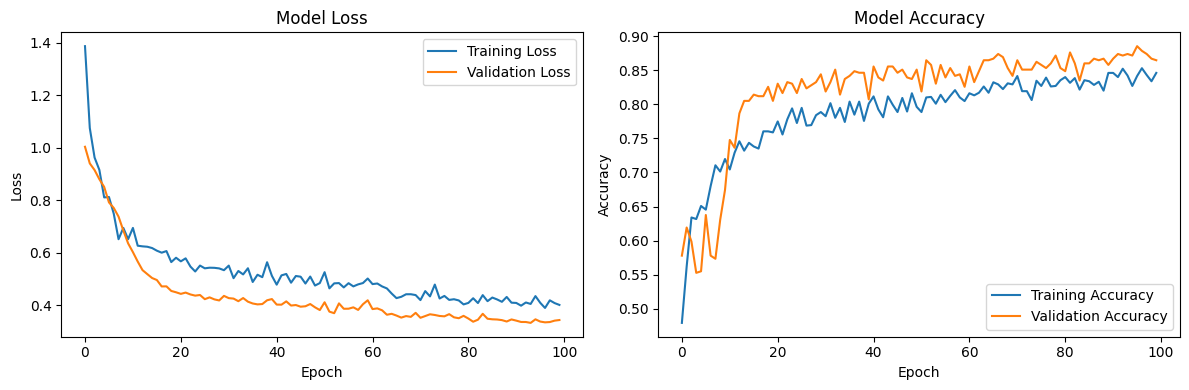

In [8]:
# ========== FINAL EVALUATION ==========
print("\n" + "="*50)
print("FINAL EVALUATION")
print("="*50)

# Evaluate on test set
test_predictions = np.argmax(final_model.predict(X_test), axis=1)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"Final Test Accuracy: {test_accuracy:.4f}")
print(f"Improvement over best baseline: {test_accuracy - best_baseline_score:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(y_test, test_predictions, target_names=status_encoder.classes_))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, test_predictions))

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(final_history.history['loss'], label='Training Loss')
plt.plot(final_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(final_history.history['accuracy'], label='Training Accuracy')
plt.plot(final_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:

# ========== CUSTOM INFERENCE FUNCTION ==========
def prediksi_stunting_custom(data_input_dict):
    """
    Custom inference function for stunting prediction
    Built from scratch without using external API services
    """
    try:
        # Load custom trained model and preprocessors
        model = tf.keras.models.load_model("model_klasifikasi_stunting_custom.h5")
        scaler = joblib.load("scaler.pkl")
        status_encoder = joblib.load("status_encoder.pkl")
        jk_encoder = joblib.load("jk_encoder.pkl")

        # Manual encoding (not using external services)
        jk_encoded = 1 if data_input_dict['JK'].lower() == 'laki-laki' else 0

        # Prepare input array
        data_array = np.array([[
            jk_encoded,
            data_input_dict['BB_Lahir'],
            data_input_dict['TB_Lahir'],
            data_input_dict['Umur'],
            data_input_dict['Berat'],
            data_input_dict['Tinggi']
        ]])

        # Scale data using our own scaler
        data_scaled = scaler.transform(data_array)

        # Make prediction using our custom model
        pred_proba = model.predict(data_scaled, verbose=0)
        pred_class = np.argmax(pred_proba, axis=1)

        # Get all class probabilities
        class_probabilities = {}
        for i, class_name in enumerate(status_encoder.classes_):
            class_probabilities[class_name] = float(pred_proba[0][i])

        # Custom confidence calculation
        confidence = float(np.max(pred_proba))
        predicted_label = status_encoder.inverse_transform(pred_class)[0]

        return {
            "predicted_label": predicted_label,
            "confidence": confidence,
            "all_probabilities": class_probabilities,
            "model_type": "Custom Built Neural Network"
        }

    except Exception as e:
        return {"error": f"Custom inference failed: {str(e)}"}

# Test custom prediction function
print("\n" + "="*50)
print("TESTING CUSTOM INFERENCE")
print("="*50)

data_test = {
    "JK": "Laki-laki",
    "BB_Lahir": 3.0,
    "TB_Lahir": 50,
    "Umur": 24,
    "Berat": 10.5,
    "Tinggi": 87
}

hasil = prediksi_stunting_custom(data_test)
if "error" not in hasil:
    print("Model Type:", hasil["model_type"])
    print("Hasil Prediksi:", hasil["predicted_label"])
    print("Tingkat Keyakinan: {:.2f}%".format(hasil["confidence"] * 100))
    print("\nProbabilitas untuk setiap kelas:")
    for class_name, prob in hasil["all_probabilities"].items():
        print(f"  {class_name}: {prob:.4f} ({prob*100:.2f}%)")
else:
    print(hasil["error"])


TESTING CUSTOM INFERENCE


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Model Type: Custom Built Neural Network
Hasil Prediksi: Normal
Tingkat Keyakinan: 70.68%

Probabilitas untuk setiap kelas:
  Normal: 0.7068 (70.68%)
  Severely Stunting: 0.0440 (4.40%)
  Stunting: 0.2492 (24.92%)
